In [102]:
import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from file_process import process_genre_folder,add_tfidf_features,debug_tfidf_features
import pandas as pd
from scipy.stats import pearsonr
import umap
from sklearn.preprocessing import StandardScaler
from scipy import stats




In [2]:
chinese_path = "../data/chinese"  # ← Change to your folder path
english_path = "../data/english"

chinese_df = process_genre_folder(chinese_path,lang="ch")
english_df = process_genre_folder(english_path,lang="en")

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache



Processing genre: history_fiction


Loading model cost 0.313 seconds.
Prefix dict has been built successfully.


  Success: 5. 步步生莲 (月关) (Z-Library).txt                       → 1,790,461 words
  Success: 3. 隋乱 (酒徒) (Z-Library).txt                         → 1,170,142 words
  Success: 2. 风起陇西 (马伯庸 [马伯庸]) (Z-Library).txt                → 142,867 words
  Success: 4. 新宋 (阿越) (Z-Library).txt                         → 1,738,158 words
  Success: 10. 历史的裂变：中国历史上的十三场政变（畅销书《大唐兴亡三百年》作者王觉仁力作，用小说笔法，讲述 → 143,503 words
  Success: 9. 辛亥：计划外革命 (雪珥) (Z-Library).txt                   → 85,673 words
  Success: 6. 宰执天下 (cuslaa) (Z-Library).txt                   → 3,852,110 words
  Success: 8. 四时歌：骑桶人自选集 (骑桶人) (Z-Library).txt                → 149,371 words
  Success: 7. 窃明 (灰熊猫) (Z-Library).txt                        → 706,476 words
  Success: 1. 长安十二时辰 (马伯庸) (Z-Library).txt                    → 237,443 words

Processing genre: horror
  Success: 5. 奇门遁甲 (周德东) (Z-Library).txt                      → 83,831 words
  Success: 7. 周德东恐怖悬疑小说合集 (周德东) (Z-Library).txt               → 2,909,210 words
  Success: 8. 必须犯规的游戏 (宁航一 [宁航

In [3]:
chinese_df[:5]

,pronoun_ratio,info_density,avg_sent_len,language,total_words,book,genre,filepath
0,0.052367,0.571288,25.932174,ch,1790461,5. 步步生莲 (月关) (Z-Library).txt,history_fiction,../data/chinese/history_fiction/5. 步步生莲 (月关) (...
1,0.041833,0.570109,14.496847,ch,1170142,3. 隋乱 (酒徒) (Z-Library).txt,history_fiction,../data/chinese/history_fiction/3. 隋乱 (酒徒) (Z-...
2,0.044160,0.580330,16.973625,ch,142867,2. 风起陇西 (马伯庸 [马伯庸]) (Z-Library).txt,history_fiction,../data/chinese/history_fiction/2. 风起陇西 (马伯庸 [...
3,0.036487,0.582155,18.071176,ch,1738158,4. 新宋 (阿越) (Z-Library).txt,history_fiction,../data/chinese/history_fiction/4. 新宋 (阿越) (Z-...
4,0.033532,0.609597,15.379166,ch,143503,10. 历史的裂变：中国历史上的十三场政变（畅销书《大唐兴亡三百年》作者王觉仁力作，用小说笔...,history_fiction,../data/chinese/history_fiction/10. 历史的裂变：中国历史...


In [4]:
english_df[:5]

,pronoun_ratio,info_density,avg_sent_len,language,total_words,book,genre,filepath
0,0.128750,0.737418,10.249726,en,149359,The Nightingale - Kristin Hannah.txt,history_fiction,../data/english/history_fiction/The Nightingal...
1,0.162136,0.744042,9.976509,en,101501,The Song of Achilles - Madeline Miller.txt,history_fiction,../data/english/history_fiction/The Song of Ac...
2,0.121740,0.721606,17.167416,en,122129,The Last Kingdom - Bernard Cornwell.txt,history_fiction,../data/english/history_fiction/The Last Kingd...
3,0.104220,0.730026,11.084851,en,320064,Fall of Giants - Ken Follett.txt,history_fiction,../data/english/history_fiction/Fall of Giants...
4,0.145869,0.734240,11.872447,en,217990,Wolf Hall - Hilary Mantel.txt,history_fiction,../data/english/history_fiction/Wolf Hall - Hi...


In [5]:
def clean_df(df, verbose=True):
    initial = len(df)
    
    # 1. Remove only real garbage (NaN / inf / empty)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=["pronoun_ratio", "info_density", 
                           "avg_sent_len","total_words"])
    
    # 2. Minimum realistic book size (skip samples/chapters)
    df = df[df["total_words"] >= 10_000]   # ← 10k words minimum (very safe)
    
    # 3. VERY LOOSE outlier removal — use 5×IQR or percentile clipping
    numeric_cols = ["pronoun_ratio", "info_density", "avg_sent_len"]
    
    for col in numeric_cols:
        # For all ratios: winsorize at 1% and 99% (keeps real variation)
        lower = df[col].quantile(0.001)
        upper = df[col].quantile(0.999)
        removed = len(df[(df[col] < lower) | (df[col] > upper)])
        df = df[df[col].between(lower, upper)]
        
        if verbose and removed > 0:
            print(f"  Removed {removed} extreme values in {col}")
    
    
    final = len(df)
    if verbose:
        print(f"\nData cleaning complete:")
        print(f"   Before → {initial} books")
        print(f"   After  → {final} books ({initial-final} removed)")
        print(f"   Kept {100*final/initial:.1f}% of the data\n")
    
    return df.reset_index(drop=True)

In [24]:
#apply cleaning
clean_ch_df = clean_df(chinese_df)
clean_en_df = clean_df(english_df)


  Removed 2 extreme values in pronoun_ratio
  Removed 2 extreme values in info_density
  Removed 2 extreme values in avg_sent_len

Data cleaning complete:
   Before → 39 books
   After  → 33 books (6 removed)
   Kept 84.6% of the data

  Removed 2 extreme values in pronoun_ratio
  Removed 2 extreme values in info_density
  Removed 2 extreme values in avg_sent_len

Data cleaning complete:
   Before → 40 books
   After  → 34 books (6 removed)
   Kept 85.0% of the data



In [26]:
#add tfidf for each df
tf_ch_df = add_tfidf_features(clean_ch_df,chinese_path)
tf_en_df = add_tfidf_features(clean_en_df,english_path)

In [32]:
bak_ch = tf_ch_df.copy()
bak_en = tf_en_df.copy()

In [35]:
#apply normalization
features = ["pronoun_ratio","info_density","avg_sent_len","tfidf_avg"]	
ch_no = tf_ch_df[features].values
ch_no = (ch_no - ch_no.mean(axis=0)) / ch_no.std(axis=0)   # ← THIS IS THE NORMALIZATION
en_no = tf_en_df[features].values
en_no = (en_no - en_no.mean(axis=0)) / en_no.std(axis=0)   # ← THIS IS THE NORMALIZATION

In [36]:
ch_no

array([[-0.41597888,  0.91529584,  1.9879655 ,  1.61667066],
       [-0.9613972 ,  0.88131186, -0.50568346,  0.13699253],
       [-0.84089526,  1.17595661,  0.03441605,  0.63732795],
       [-1.23816617,  1.22857636,  0.273754  ,  1.46427811],
       [-1.39113499,  2.0196187 , -0.31328018,  0.62674788],
       [ 0.12401706, -1.23046148,  2.40324702,  0.4214221 ],
       [-1.27884874,  0.84181322,  0.68571358, -1.37971157],
       [-1.17025605,  1.32682607, -0.59405976,  0.4972504 ],
       [ 1.48812708, -0.91391635, -1.045688  , -1.66197889],
       [ 1.29598226, -1.57927913, -0.76674605,  0.36182943],
       [ 1.23644037, -0.98493462, -0.89614057,  0.53859021],
       [ 1.29025908, -0.9787102 ,  0.05165257, -0.72731694],
       [-1.65615043,  0.21547447,  1.43742939, -0.43207005],
       [-0.84434262, -0.2845644 ,  3.0631966 , -0.45551767],
       [-0.03253692, -0.5503767 , -0.0659136 , -2.75885418],
       [-0.17295058,  0.06234481, -0.26771266,  0.90026737],
       [ 0.28546964,  1.

In [37]:
en_no

array([[-0.13034024,  0.10740002, -0.5472471 , -1.06223818],
       [ 1.47274761,  0.61235006, -0.69342955, -0.68268288],
       [-1.30820637, -0.45609451, -0.10041963,  0.41860183],
       [ 0.69164978, -0.13484346,  0.32097713,  0.04132248],
       [ 0.88946115, -0.27215437,  0.45633789, -0.0739469 ],
       [-1.97159304, -1.15248265,  0.26715606,  0.35824438],
       [-0.14398617, -0.9767542 ,  2.50838399,  1.94492007],
       [-1.04745625, -0.04501921, -1.03466288,  1.39683844],
       [ 0.62722311,  0.31275426, -1.0985361 , -0.7164199 ],
       [ 0.21308412,  0.43870779, -0.17948174, -0.55276303],
       [-0.15706787, -0.13340165, -0.17923577,  1.91815366],
       [-0.34861737, -0.36525649,  0.88897849, -1.74471151],
       [-0.56338607,  0.88514125,  0.5756449 , -1.51603509],
       [-0.76050479,  0.14705411, -0.47812363, -0.351786  ],
       [-0.2518102 , -0.48060726,  0.5402691 ,  1.09328803],
       [ 0.3276506 ,  0.59894388, -0.27575749, -0.44889367],
       [ 0.30960136, -1.

In [38]:
pro_ch_df = tf_ch_df
# Give normalized values back to df
for i, col in enumerate(features):
    pro_ch_df[f"{col}"] = ch_no[:, i]

In [39]:
pro_en_df = tf_en_df
# Give normalized values back to df
for i, col in enumerate(features):
    pro_en_df[f"{col}"] = en_no[:, i]

In [43]:
df = pd.concat([pro_en_df, pro_ch_df], ignore_index=True)

In [44]:
# pca_df = df.dropna(subset=["pronoun_ratio", "info_density", "avg_sent_len","tfidf_avg"]).reset_index(drop=True)

# Now PCA will work perfectly
pca_X = df[features]

In [45]:
pca_X

,pronoun_ratio,info_density,avg_sent_len,tfidf_avg
0,-0.130340,0.107400,-0.547247,-1.062238
1,1.472748,0.612350,-0.693430,-0.682683
2,-1.308206,-0.456095,-0.100420,0.418602
3,0.691650,-0.134843,0.320977,0.041322
4,0.889461,-0.272154,0.456338,-0.073947
...,...,...,...,...
62,1.695187,-1.511967,-0.554985,0.262656
63,0.534087,-0.033544,-0.736333,-1.101471
64,1.161043,-1.405816,-0.491059,0.204537
65,1.303868,-0.423448,-1.042399,1.722720


/home/ubuntu-user/anaconda3/envs/lingu/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


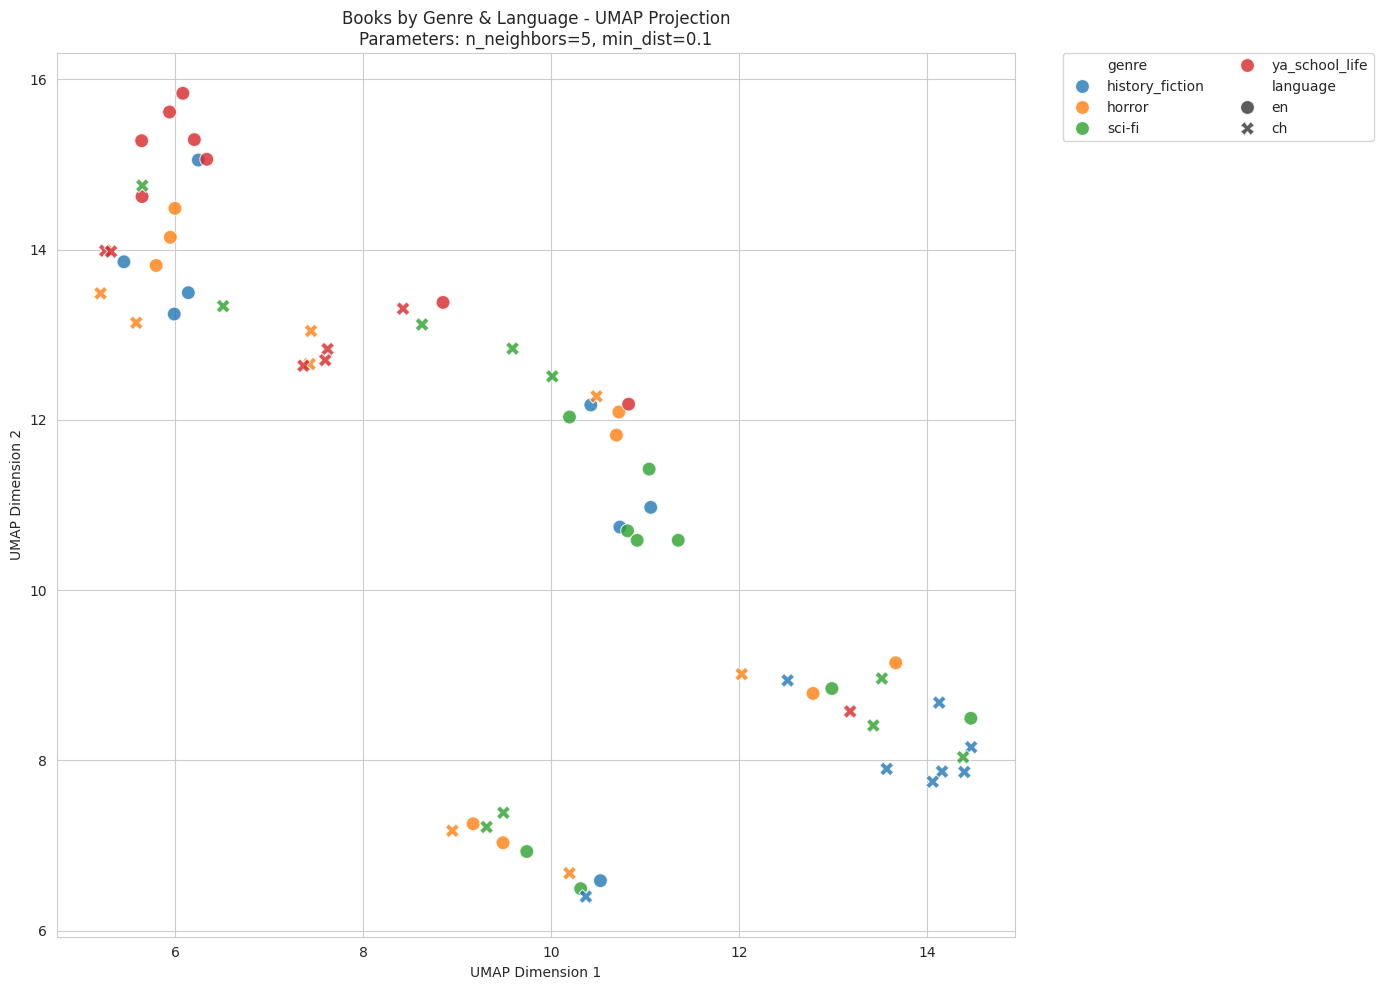

In [68]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pca_X)

# Try different parameter combinations
# param_grid = [
#     {'n_neighbors': 5, 'min_dist': 0.1},   # More local structure
#     {'n_neighbors': 15, 'min_dist': 0.1},  # Default
#     {'n_neighbors': 30, 'min_dist': 0.1},  # More global structure
#     {'n_neighbors': 15, 'min_dist': 0.0},  # Tight clusters
#     {'n_neighbors': 15, 'min_dist': 0.5},  # Spread out clusters
# ]

# fig, axes = plt.subplots(2, 3, figsize=(18, 12))
# axes = axes.flat

# for i, params in enumerate(param_grid):
#     # Apply UMAP
#     reducer = umap.UMAP(
#         n_components=2,
#         n_neighbors=params['n_neighbors'],
#         min_dist=params['min_dist'],
#         random_state=42,
#         metric='euclidean'  # Try 'cosine' if you have text/TF-IDF features
#     )
    
#     umap_result = reducer.fit_transform(X_scaled)
    
#     # Create temporary dataframe for plotting
#     temp_df = df.copy()
#     temp_df['umap1'] = umap_result[:, 0]
#     temp_df['umap2'] = umap_result[:, 1]
    
#     # Plot
#     sns.scatterplot(
#         data=temp_df,
#         x="umap1", y="umap2",
#         hue="genre",
#         s=60,
#         alpha=0.8,
#         ax=axes[i]
#     )
    
#     axes[i].set_title(f"UMAP: n_neighbors={params['n_neighbors']}, min_dist={params['min_dist']}")
#     axes[i].set_xlabel("")
#     axes[i].set_ylabel("")
#     axes[i].legend().remove()

# # Add PCA for comparison in the last subplot
# axes[-1].scatter(df["pca1"], df["pca2"], c=pd.factorize(df["genre"])[0], cmap='tab20', s=60, alpha=0.8)
# axes[-1].set_title(f"PCA (Var: {pca.explained_variance_ratio_.sum():.1%})")

# plt.suptitle("UMAP Parameter Exploration vs PCA", fontsize=16, y=1.02)
# plt.tight_layout()
# plt.show()

# Choose the best looking visualization and apply it to your main dataframe
best_reducer = umap.UMAP(
    n_components=2,
    n_neighbors=5,  # Adjust based on what looked best
    min_dist=0.1,    # Adjust based on what looked best
    random_state=42,
    metric='euclidean'
)

final_umap = best_reducer.fit_transform(X_scaled)
df["umap1"] = final_umap[:, 0]
df["umap2"] = final_umap[:, 1]

# Use categorical palette with maximum contrast
if len(df['genre'].unique()) <= 10:
    palette = "tab10"  # 10 distinct colors
elif len(df['genre'].unique()) <= 20:
    palette = "tab20"  # 20 distinct colors
else:
    palette = "gist_ncar"  # Many distinct color
# Final visualization with both color and style
plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(
    data=df,
    x="umap1", y="umap2",
    hue="genre",
    style="language",
    s=100,
    alpha=0.8,
    palette=palette
)

plt.title(f"Books by Genre & Language - UMAP Projection\n"
          f"Parameters: n_neighbors={best_reducer.n_neighbors}, min_dist={best_reducer.min_dist}")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")

# Move legend outside
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0,
    ncol=2 if len(df['language'].unique()) > 1 else 1
)

plt.tight_layout()
plt.show()

# Save final results
df.to_csv("analysis_with_umap_final.csv", index=False)


PEARSON CORRELATION: English vs Chinese Stylistic Similarity (by Genre)
             genre  n_en  n_zh  pearson_r  p_value  significant
1           horror     9     8     0.5503   0.4497        False
3   ya_school_life     8     7     0.4048   0.5952        False
0  history_fiction     8     8     0.2231   0.7769        False
2           sci-fi     9    10    -0.5200   0.4800        False

Strong cross-language similarity (r > 0.7):
Empty DataFrame
Columns: [genre, pearson_r, n_en, n_zh]
Index: []


Text(0.5, 1.0, 'How Similar Are English & Chinese Books in the Same Genre?\nHigher r = More similar stylistic profile')

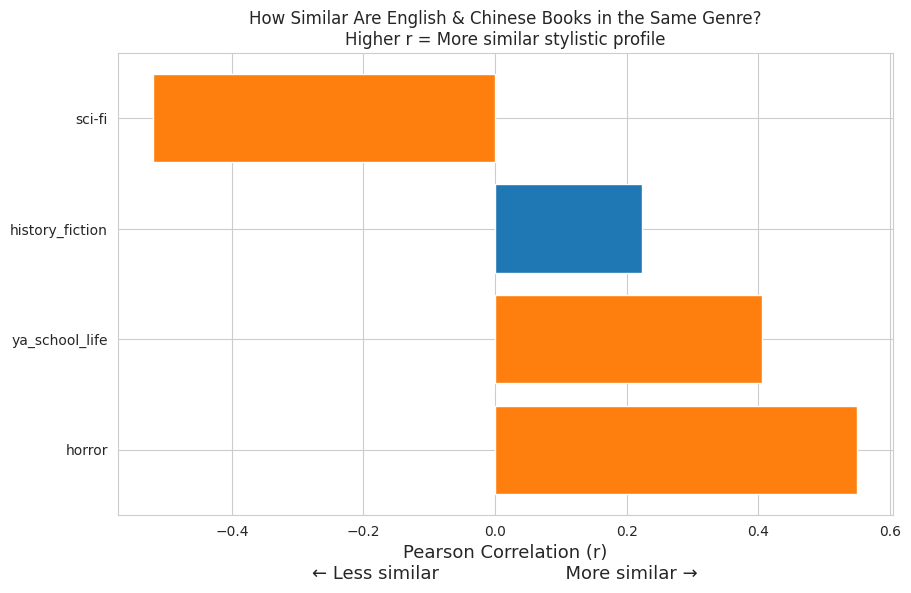

In [61]:
# ────────────────────────
# 1. Normalize the 3 features (same as before)
# ────────────────────────
features = ["pronoun_ratio", "info_density", "avg_sent_len","tfidf_avg"]
df = df.dropna(subset=features + ["genre", "language"]).reset_index(drop=True)

X = df[features].values
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)
for i, col in enumerate(features):
    df[f"{col}_norm"] = X_norm[:, i]

# Use only normalized features for comparison
norm_cols = [f"{f}_norm" for f in features]

# ────────────────────────
# 2. Pearson correlation: EN vs ZH within same genre
# ────────────────────────
results = []

for genre in df["genre"].unique():
    en_books = df[(df["genre"] == genre) & (df["language"] == "en")][norm_cols]
    zh_books = df[(df["genre"] == genre) & (df["language"] == "ch")][norm_cols]
    
    if len(en_books) < 2 or len(zh_books) < 2:
        print(f"Skipping {genre}: not enough books (EN={len(en_books)}, CH={len(zh_books)})")
        continue
    
    # Average stylistic profile per language
    en_mean = en_books.mean()
    zh_mean = zh_books.mean()
    
    # Pearson correlation between the two average vectors
    r, p = pearsonr(en_mean, zh_mean)
    
    results.append({
        "genre": genre,
        "n_en": len(en_books),
        "n_zh": len(zh_books),
        "pearson_r": r,
        "p_value": p,
        "significant": p < 0.05
    })

# Convert to DataFrame
corr_df = pd.DataFrame(results)
corr_df = corr_df.sort_values("pearson_r", ascending=False)

# ────────────────────────
# 3. Display results
# ────────────────────────
print("\nPEARSON CORRELATION: English vs Chinese Stylistic Similarity (by Genre)")
print("="*80)
print(corr_df.round(4))

# Highlight strong similarity
print("\nStrong cross-language similarity (r > 0.7):")
print(corr_df[corr_df["pearson_r"] > 0.7][["genre", "pearson_r", "n_en", "n_zh"]])

# ────────────────────────
# 4. Beautiful bar plot
# ────────────────────────
plt.figure(figsize=(10, 6))
bars = plt.barh(corr_df["genre"], corr_df["pearson_r"], 
                color=np.where(abs(corr_df["pearson_r"]) > 0.7, "#d62728", 
                       np.where(abs(corr_df["pearson_r"]) > 0.4, "#ff7f0e", "#1f77b4")))

plt.xlabel("Pearson Correlation (r)\n← Less similar                      More similar →", fontsize=13)
plt.title("How Similar Are English & Chinese Books in the Same Genre?\n"
          "Higher r = More similar stylistic profile")

/tmp/ipykernel_102758/2449243477.py:59: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  sns.barplot(data=feature_data,
/tmp/ipykernel_102758/2449243477.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
/tmp/ipykernel_102758/2449243477.py:59: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  sns.barplot(data=feature_data,
/tmp/ipykernel_102758/2449243477.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
/tmp/ipykernel_102758/2449243477.py:59: FutureWarning: 

The `errwidth` parameter is deprecated.

<Figure size 1400x1000 with 0 Axes>

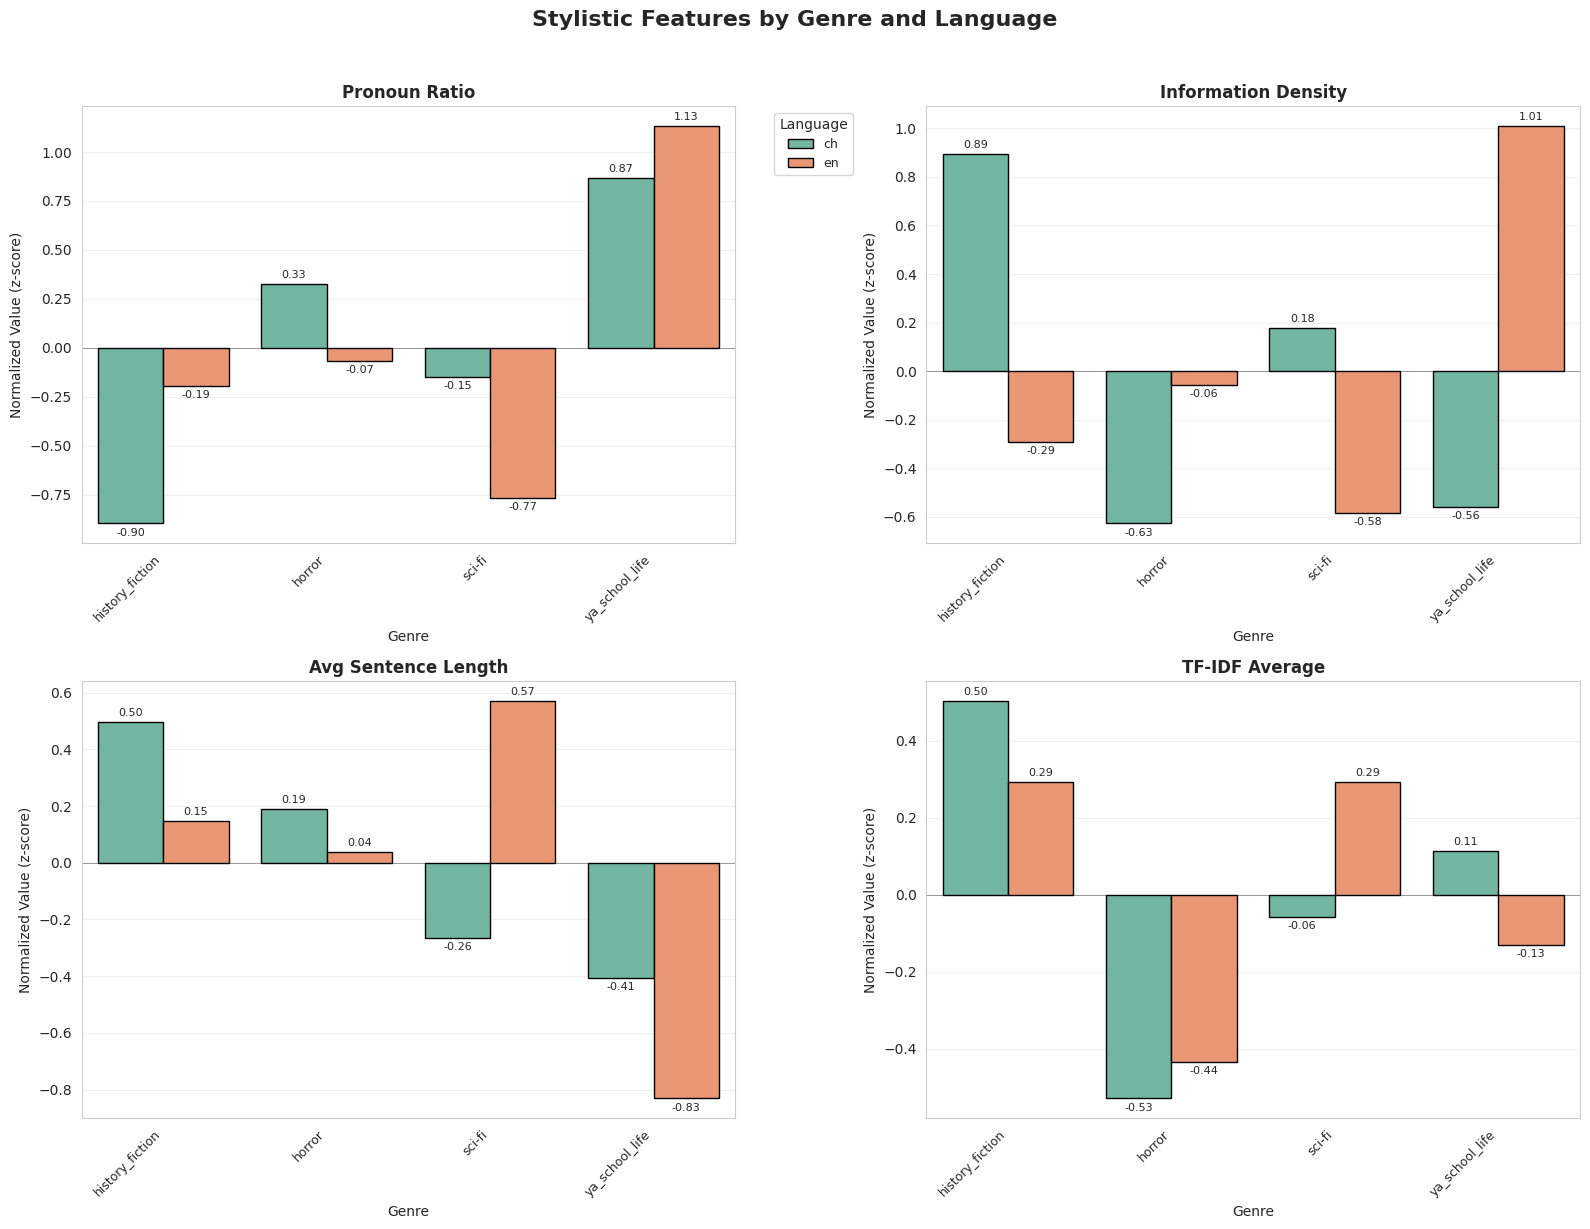

In [70]:
features = ["pronoun_ratio", "info_density", "avg_sent_len", "tfidf_avg"]
df = df.dropna(subset=features + ["genre", "language"]).reset_index(drop=True)

X = df[features].values
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)

for i, col in enumerate(features):
    df[f"{col}_norm"] = X_norm[:, i]

norm_cols = [f"{f}_norm" for f in features]

# ────────────────────────
# Compute mean normalized features per genre and language
# ────────────────────────
mean_df = (
    df.groupby(["genre", "language"])[norm_cols]
      .mean()
      .reset_index()
)

# Melt for easier plotting with seaborn
mean_melted = mean_df.melt(
    id_vars=["genre", "language"],
    value_vars=norm_cols,
    var_name="feature",
    value_name="mean_normalized_value"
)

# Clean up feature names for nicer display
feature_names = {
    "pronoun_ratio_norm": "Pronoun Ratio",
    "info_density_norm": "Information Density", 
    "avg_sent_len_norm": "Avg Sentence Length",
    "tfidf_avg_norm": "TF-IDF Average"
}
mean_melted["feature"] = mean_melted["feature"].map(feature_names)

# ────────────────────────
# OPTION 1: Enhanced grouped bar chart with genre colors
# ────────────────────────

# Create a color palette for genres
genres = mean_melted["genre"].unique()
genre_palette = sns.color_palette("husl", len(genres))
genre_color_dict = dict(zip(genres, genre_palette))

plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")

# Create a single figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, feature in enumerate(features_order):
    ax = axes[idx]
    feature_data = mean_melted[mean_melted["feature"] == feature]
    
    # Use seaborn barplot for simplicity
    sns.barplot(data=feature_data,
                x="genre",
                y="mean_normalized_value",
                hue="language",
                ax=ax,
                palette="Set2",  # Distinct colors for languages
                edgecolor='black',
                linewidth=1,
                errwidth=0)  # Remove error bars
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3, fontsize=8)
    
    ax.set_title(f"{feature}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Genre", fontsize=10)
    ax.set_ylabel("Normalized Value (z-score)", fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    
    # Move legend outside for first plot only
    if idx == 0:
        ax.legend(title="Language", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    else:
        ax.legend().remove()

fig.suptitle("Stylistic Features by Genre and Language", 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Genres sorted by distinctiveness (average |z-score|):
  ya_school_life: 0.631
  history_fiction: 0.464
  sci-fi: 0.357
  horror: 0.283


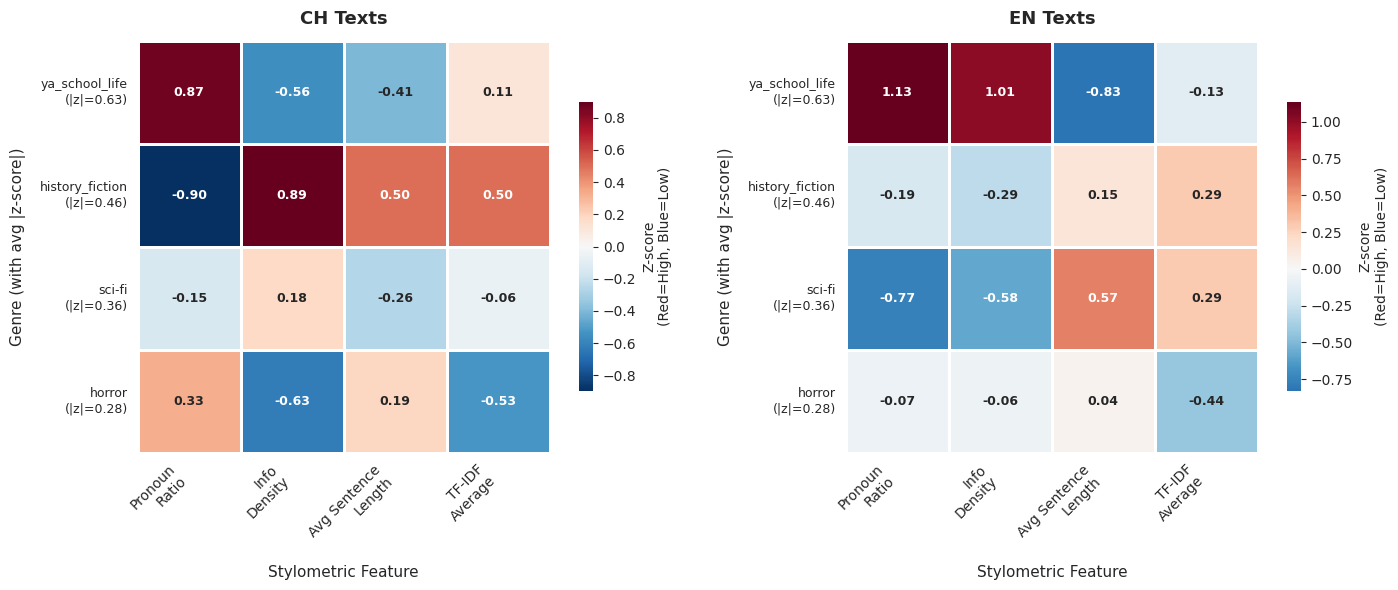

Genres sorted by distinctiveness (average |z-score|):
  ya_school_life: 0.631
  history_fiction: 0.464
  sci-fi: 0.357
  horror: 0.283


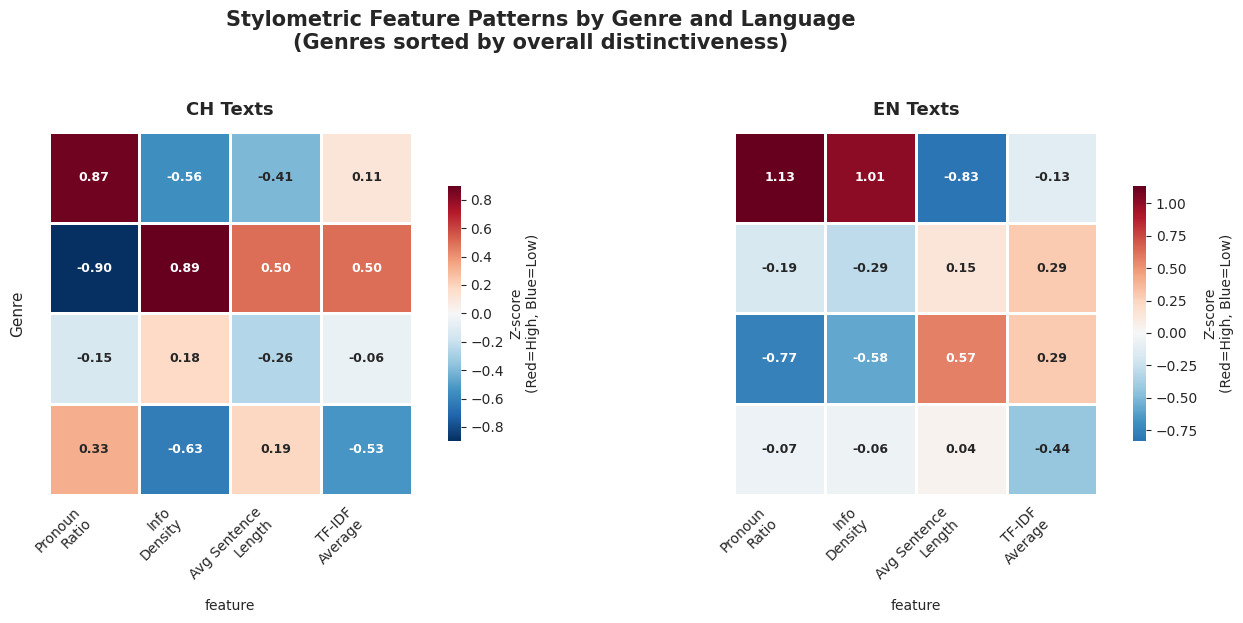

In [105]:
# Ensure data is prepared
features = ["pronoun_ratio", "info_density", "avg_sent_len", "tfidf_avg"]
df = df.dropna(subset=features + ["genre", "language"]).reset_index(drop=True)

# Normalize features
X = df[features].values
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)
# Create detailed y-tick labels with distinctiveness score
y_tick_labels = [f"{genre}\n(|z|={genre_avg_z[genre]:.2f})" for genre in genres]

for i, col in enumerate(features):
    df[f"{col}_norm"] = X_norm[:, i]

norm_cols = [f"{f}_norm" for f in features]

# ────────────────────────
# Compute mean normalized features per genre and language
# ────────────────────────
mean_df = (
    df.groupby(["genre", "language"])[norm_cols]
      .mean()
      .reset_index()
)

# Clean up feature names for nicer display
feature_names = {
    "pronoun_ratio_norm": "Pronoun\nRatio",
    "info_density_norm": "Info\nDensity", 
    "avg_sent_len_norm": "Avg Sentence\nLength",
    "tfidf_avg_norm": "TF-IDF\nAverage"
}

# Rename columns in mean_df for display
mean_df_display = mean_df.rename(columns=feature_names)

# Get display feature names
display_features = list(feature_names.values())

# Get unique languages and genres
languages = sorted(mean_df_display['language'].unique())

# ────────────────────────
# Sort genres by their average z-score across all features
# ────────────────────────

# Calculate average absolute z-score for each genre (across all features and languages)
genre_avg_z = {}
for genre in mean_df_display['genre'].unique():
    genre_data = mean_df_display[mean_df_display['genre'] == genre]
    avg_z = genre_data[display_features].abs().mean().mean()  # Average absolute value
    genre_avg_z[genre] = avg_z

# Sort genres by their average z-score (most distinctive first)
genres = sorted(genre_avg_z.keys(), key=lambda x: genre_avg_z[x], reverse=True)

print("Genres sorted by distinctiveness (average |z-score|):")
for genre in genres:
    print(f"  {genre}: {genre_avg_z[genre]:.3f}")

# ────────────────────────
# Create heatmap with sorted genres
# ────────────────────────

# Prepare data for facet grid
heatmap_data = mean_df_display.melt(id_vars=['genre', 'language'], 
                                     value_vars=display_features,
                                     var_name='feature',
                                     value_name='z_score')

# Create facet grid
g = sns.FacetGrid(heatmap_data, 
                  col='language', 
                  height=6, 
                  aspect=1.2,
                  sharey=True)

# Define plotting function
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    
    # Pivot the data
    pivot_data = data.pivot(index='genre', 
                            columns='feature', 
                            values='z_score')
    
    # Reindex to ensure consistent order - using the sorted 'genres'
    pivot_data = pivot_data.reindex(index=genres, columns=display_features)
    
    # Draw heatmap
    sns.heatmap(pivot_data,
                annot=True,
                fmt=".2f",
                cmap="RdBu_r",
                center=0,
                cbar_kws={'label': 'Z-score\n(Red=High, Blue=Low)', 'shrink': 0.7},
                linewidths=1,
                linecolor='white',
                square=True,
                yticklabels=y_tick_labels,
                annot_kws={'size': 9, 'weight': 'bold'},
                **kwargs)

# Map the plotting function
g.map_dataframe(draw_heatmap)

# Customize titles and labels
for ax, language in zip(g.axes.flat, languages):
    ax.set_title(f"{language.upper()} Texts", fontsize=13, fontweight='bold', pad=12)
    ax.set_ylabel("Genre", fontsize=11, labelpad=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

g.fig.suptitle("Stylometric Feature Patterns by Genre and Language\n"
               "(Genres sorted by overall distinctiveness)", 
               fontsize=15, fontweight='bold', y=1.03)

plt.tight_layout()
plt.show()




In [111]:
df

,pronoun_ratio,info_density,avg_sent_len,language,total_words,book,genre,filepath,tfidf_avg,pca1,pca2,pronoun_ratio_norm,info_density_norm,avg_sent_len_norm,tfidf_avg_norm,umap1,umap2
0,-0.130340,0.107400,-0.547247,en,149359,The Nightingale - Kristin Hannah.txt,history_fiction,../data/english/history_fiction/The Nightingal...,-1.062238,-0.683289,0.042503,-0.130340,0.107400,-0.547247,-1.062238,5.453007,13.856578
1,1.472748,0.612350,-0.693430,en,101501,The Song of Achilles - Madeline Miller.txt,history_fiction,../data/english/history_fiction/The Song of Ac...,-0.682683,-1.675061,-0.479731,1.472748,0.612350,-0.693430,-0.682683,6.244404,15.052033
2,-1.308206,-0.456095,-0.100420,en,320064,Fall of Giants - Ken Follett.txt,history_fiction,../data/english/history_fiction/Fall of Giants...,0.418602,0.897780,0.527063,-1.308206,-0.456095,-0.100420,0.418602,11.059678,10.971647
3,0.691650,-0.134843,0.320977,en,217990,Wolf Hall - Hilary Mantel.txt,history_fiction,../data/english/history_fiction/Wolf Hall - Hi...,0.041322,-0.061458,-0.547175,0.691650,-0.134843,0.320977,0.041322,6.138467,13.493646
4,0.889461,-0.272154,0.456338,en,141904,Bring Up the Bodies - Hilary Mantel.txt,history_fiction,../data/english/history_fiction/Bring Up the B...,-0.073947,-0.049485,-0.802725,0.889461,-0.272154,0.456338,-0.073947,5.988163,13.242958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,1.695187,-1.511967,-0.554985,ch,131819,1. 最好的我们 (八月长安 [八月长安]) (Z-Library).txt,ya_school_life,../data/chinese/ya_school_life/1. 最好的我们 (八月长安 ...,0.262656,-0.575043,-2.095409,1.695187,-1.511967,-0.554985,0.262656,7.595441,12.701002
63,0.534087,-0.033544,-0.736333,ch,57412,5. 云边有个小卖部（张嘉佳全新力作！写给我们所遇见的悲伤和希望，和路上从未断绝的一缕光！）...,ya_school_life,../data/chinese/ya_school_life/5. 云边有个小卖部（张嘉佳全...,-1.101471,-1.108129,-0.460031,0.534087,-0.033544,-0.736333,-1.101471,5.253937,13.987090
64,1.161043,-1.405816,-0.491059,ch,210332,10. 暗恋·橘生淮南 (八月长安 [八月长安]) (Z-Library).txt,ya_school_life,../data/chinese/ya_school_life/10. 暗恋·橘生淮南 (八月...,0.204537,-0.319577,-1.703166,1.161043,-1.405816,-0.491059,0.204537,7.363704,12.635376
65,1.303868,-0.423448,-1.042399,ch,520852,8. 玖月晞亲爱的系列（套装2册） (玖月晞 [jiuyuexi]) (Z-Library)...,ya_school_life,../data/chinese/ya_school_life/8. 玖月晞亲爱的系列（套装2...,1.722720,-0.689701,-0.754416,1.303868,-0.423448,-1.042399,1.722720,8.423312,13.305703


In [112]:
import numpy as np
import pandas as pd
from scipy import stats
from itertools import combinations

# ────────────────────────
# 1. Prepare data
# ────────────────────────
features = ["pronoun_ratio", "info_density", "avg_sent_len", "tfidf_avg"]
df = df.dropna(subset=features + ["genre", "language"]).reset_index(drop=True)

# Normalize features
X = df[features].values
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)

for i, col in enumerate(features):
    df[f"{col}_norm"] = X_norm[:, i]

norm_cols = [f"{f}_norm" for f in features]

# ────────────────────────
# 2. Compute mean normalized features per genre and language
# ────────────────────────
mean_df = (
    df.groupby(["genre", "language"])[norm_cols]
      .mean()
      .reset_index()
)

# Feature name mapping for display
feature_names = {
    "pronoun_ratio_norm": "Pronoun Ratio",
    "info_density_norm": "Info Density", 
    "avg_sent_len_norm": "Avg Sentence Length",
    "tfidf_avg_norm": "TF-IDF Average"
}

# Get unique languages
languages = sorted(mean_df['language'].unique())
genres = sorted(mean_df['genre'].unique())

# ────────────────────────
# 3. Function to calculate correlations between language pairs
# for specific genre-feature combinations
# ────────────────────────





In [141]:
X_norm

array([[-0.13034024,  0.10740002, -0.5472471 , -1.06223818],
       [ 1.47274761,  0.61235006, -0.69342955, -0.68268288],
       [-1.30820637, -0.45609451, -0.10041963,  0.41860183],
       [ 0.69164978, -0.13484346,  0.32097713,  0.04132248],
       [ 0.88946115, -0.27215437,  0.45633789, -0.0739469 ],
       [-1.97159304, -1.15248265,  0.26715606,  0.35824438],
       [-0.14398617, -0.9767542 ,  2.50838399,  1.94492007],
       [-1.04745625, -0.04501921, -1.03466288,  1.39683844],
       [ 0.62722311,  0.31275426, -1.0985361 , -0.7164199 ],
       [ 0.21308412,  0.43870779, -0.17948174, -0.55276303],
       [-0.15706787, -0.13340165, -0.17923577,  1.91815366],
       [-0.34861737, -0.36525649,  0.88897849, -1.74471151],
       [-0.56338607,  0.88514125,  0.5756449 , -1.51603509],
       [-0.76050479,  0.14705411, -0.47812363, -0.351786  ],
       [-0.2518102 , -0.48060726,  0.5402691 ,  1.09328803],
       [ 0.3276506 ,  0.59894388, -0.27575749, -0.44889367],
       [ 0.30960136, -1.

In [139]:
def calculate_cross_language_correlations():
    """Calculate correlations between all language pairs for each genre-feature combination"""
    results = []
    # For each feature and genre
    for original_feature, display_name in feature_names.items():
        for genre in genres:
            # Get data for this genre-feature combination
            genre_data = mean_df[mean_df['genre'] == genre][['language', original_feature]]
            

            # Get values for each language
            val1 = genre_data[genre_data['language'] == "ch"][original_feature].values
            val2 = genre_data[genre_data['language'] == "en"][original_feature].values
            
            # Check if both languages have data
            if len(val1) > 0 and len(val2) > 0:
                print(f"val1: {val1}, val2: {val2}")
                # Calculate Pearson correlation
                corr, p_value = stats.pearsonr(val1, val2)
                # Store result
                results.append({
                    'feature': display_name,
                    'genre': genre,
                    'language_pair': "ch-en",
                    'correlation': corr,
                    'abs_correlation': abs(corr),
                    'p_value': p_value,
                    'is_significant': p_value < 0.5,
                    'is_highly_significant': p_value < 0.01
                })
    
    return pd.DataFrame(results)

# ────────────────────────
# 4. Calculate and filter significant relationships
# ────────────────────────
correlations_df = calculate_cross_language_correlations()

val1: [-0.89658253], val2: [-0.19346544]


ValueError: `x` and `y` must have length at least 2.

In [149]:
df

,pronoun_ratio,info_density,avg_sent_len,language,total_words,book,genre,filepath,tfidf_avg,pca1,pca2,pronoun_ratio_norm,info_density_norm,avg_sent_len_norm,tfidf_avg_norm,umap1,umap2
0,-0.130340,0.107400,-0.547247,en,149359,The Nightingale - Kristin Hannah.txt,history_fiction,../data/english/history_fiction/The Nightingal...,-1.062238,-0.683289,0.042503,-0.130340,0.107400,-0.547247,-1.062238,5.453007,13.856578
1,1.472748,0.612350,-0.693430,en,101501,The Song of Achilles - Madeline Miller.txt,history_fiction,../data/english/history_fiction/The Song of Ac...,-0.682683,-1.675061,-0.479731,1.472748,0.612350,-0.693430,-0.682683,6.244404,15.052033
2,-1.308206,-0.456095,-0.100420,en,320064,Fall of Giants - Ken Follett.txt,history_fiction,../data/english/history_fiction/Fall of Giants...,0.418602,0.897780,0.527063,-1.308206,-0.456095,-0.100420,0.418602,11.059678,10.971647
3,0.691650,-0.134843,0.320977,en,217990,Wolf Hall - Hilary Mantel.txt,history_fiction,../data/english/history_fiction/Wolf Hall - Hi...,0.041322,-0.061458,-0.547175,0.691650,-0.134843,0.320977,0.041322,6.138467,13.493646
4,0.889461,-0.272154,0.456338,en,141904,Bring Up the Bodies - Hilary Mantel.txt,history_fiction,../data/english/history_fiction/Bring Up the B...,-0.073947,-0.049485,-0.802725,0.889461,-0.272154,0.456338,-0.073947,5.988163,13.242958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,1.695187,-1.511967,-0.554985,ch,131819,1. 最好的我们 (八月长安 [八月长安]) (Z-Library).txt,ya_school_life,../data/chinese/ya_school_life/1. 最好的我们 (八月长安 ...,0.262656,-0.575043,-2.095409,1.695187,-1.511967,-0.554985,0.262656,7.595441,12.701002
63,0.534087,-0.033544,-0.736333,ch,57412,5. 云边有个小卖部（张嘉佳全新力作！写给我们所遇见的悲伤和希望，和路上从未断绝的一缕光！）...,ya_school_life,../data/chinese/ya_school_life/5. 云边有个小卖部（张嘉佳全...,-1.101471,-1.108129,-0.460031,0.534087,-0.033544,-0.736333,-1.101471,5.253937,13.987090
64,1.161043,-1.405816,-0.491059,ch,210332,10. 暗恋·橘生淮南 (八月长安 [八月长安]) (Z-Library).txt,ya_school_life,../data/chinese/ya_school_life/10. 暗恋·橘生淮南 (八月...,0.204537,-0.319577,-1.703166,1.161043,-1.405816,-0.491059,0.204537,7.363704,12.635376
65,1.303868,-0.423448,-1.042399,ch,520852,8. 玖月晞亲爱的系列（套装2册） (玖月晞 [jiuyuexi]) (Z-Library)...,ya_school_life,../data/chinese/ya_school_life/8. 玖月晞亲爱的系列（套装2...,1.722720,-0.689701,-0.754416,1.303868,-0.423448,-1.042399,1.722720,8.423312,13.305703


In [155]:
mean_df

,genre,language,Pronoun Ratio,Info Density,Avg Sentence Length,TF-IDF Average
0,history_fiction,ch,-0.896583,0.894867,0.496509,0.502622
1,history_fiction,en,-0.193465,-0.289700,0.147137,0.292632
2,horror,ch,0.325604,-0.626745,0.188760,-0.529381
3,horror,en,-0.067092,-0.056986,0.038221,-0.435203
4,sci-fi,ch,-0.150351,0.177299,-0.263714,-0.057256
5,sci-fi,en,-0.767123,-0.582249,0.569483,0.291596
6,ya_school_life,ch,0.867335,-0.559709,-0.406430,0.112376
7,ya_school_life,en,1.131958,1.008840,-0.830804,-0.131074


In [186]:
df

,pronoun_ratio,info_density,avg_sent_len,language,total_words,book,genre,filepath,tfidf_avg,pca1,pca2,pronoun_ratio_norm,info_density_norm,avg_sent_len_norm,tfidf_avg_norm,umap1,umap2
0,-0.130340,0.107400,-0.547247,en,149359,The Nightingale - Kristin Hannah.txt,history_fiction,../data/english/history_fiction/The Nightingal...,-1.062238,-0.683289,0.042503,-0.130340,0.107400,-0.547247,-1.062238,5.453007,13.856578
1,1.472748,0.612350,-0.693430,en,101501,The Song of Achilles - Madeline Miller.txt,history_fiction,../data/english/history_fiction/The Song of Ac...,-0.682683,-1.675061,-0.479731,1.472748,0.612350,-0.693430,-0.682683,6.244404,15.052033
2,-1.308206,-0.456095,-0.100420,en,320064,Fall of Giants - Ken Follett.txt,history_fiction,../data/english/history_fiction/Fall of Giants...,0.418602,0.897780,0.527063,-1.308206,-0.456095,-0.100420,0.418602,11.059678,10.971647
3,0.691650,-0.134843,0.320977,en,217990,Wolf Hall - Hilary Mantel.txt,history_fiction,../data/english/history_fiction/Wolf Hall - Hi...,0.041322,-0.061458,-0.547175,0.691650,-0.134843,0.320977,0.041322,6.138467,13.493646
4,0.889461,-0.272154,0.456338,en,141904,Bring Up the Bodies - Hilary Mantel.txt,history_fiction,../data/english/history_fiction/Bring Up the B...,-0.073947,-0.049485,-0.802725,0.889461,-0.272154,0.456338,-0.073947,5.988163,13.242958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,1.695187,-1.511967,-0.554985,ch,131819,1. 最好的我们 (八月长安 [八月长安]) (Z-Library).txt,ya_school_life,../data/chinese/ya_school_life/1. 最好的我们 (八月长安 ...,0.262656,-0.575043,-2.095409,1.695187,-1.511967,-0.554985,0.262656,7.595441,12.701002
63,0.534087,-0.033544,-0.736333,ch,57412,5. 云边有个小卖部（张嘉佳全新力作！写给我们所遇见的悲伤和希望，和路上从未断绝的一缕光！）...,ya_school_life,../data/chinese/ya_school_life/5. 云边有个小卖部（张嘉佳全...,-1.101471,-1.108129,-0.460031,0.534087,-0.033544,-0.736333,-1.101471,5.253937,13.987090
64,1.161043,-1.405816,-0.491059,ch,210332,10. 暗恋·橘生淮南 (八月长安 [八月长安]) (Z-Library).txt,ya_school_life,../data/chinese/ya_school_life/10. 暗恋·橘生淮南 (八月...,0.204537,-0.319577,-1.703166,1.161043,-1.405816,-0.491059,0.204537,7.363704,12.635376
65,1.303868,-0.423448,-1.042399,ch,520852,8. 玖月晞亲爱的系列（套装2册） (玖月晞 [jiuyuexi]) (Z-Library)...,ya_school_life,../data/chinese/ya_school_life/8. 玖月晞亲爱的系列（套装2...,1.722720,-0.689701,-0.754416,1.303868,-0.423448,-1.042399,1.722720,8.423312,13.305703


In [188]:
df['pronoun_ratio'].mean()

np.float64(5.70024955926946e-16)

In [ ]:
def get_similarity(val1,val2):
    """
    Hellinger similarity between two normal distributions.
    Returns value from 0 (different) to 1 (identical).
    """
    mean1 = np.mean(val1)
    mean2 = np.mean(val2)
    std1 = np.std(val1)
    std2 = np.std(val2)

    # For normal distributions N(μ₁, σ₁²) and N(μ₂, σ₂²)
    sigma1_sq = std1**2
    sigma2_sq = std2**2
    
    term1 = (2 * std1 * std2) / (sigma1_sq + sigma2_sq)
    term2 = np.exp(-0.25 * (mean1 - mean2)**2 / (sigma1_sq + sigma2_sq))
    
    hellinger = np.sqrt(1 - np.sqrt(term1) * term2)
    similarity = 1 - hellinger  # Convert distance to similarity
    
    return similarity



In [190]:
def calculate_feature_correlations_by_genre(df, features):
    """Calculate feature correlations within each genre using individual text data"""
    results = []
    get_ch_df = df[df['language'] == 'ch']
    get_en_df = df[df['language'] == 'en']
    feature_pairs = list(combinations(features, 2))
    
    for genre in df['genre'].unique():
        genre_data = df[df['genre'] == genre]
        
        for feat1, feat2 in feature_pairs:
            # Use individual text values, not means!
            vals1 = get_ch_df[feat1].values
            vals2 = get_en_df[feat2].values
            print(f"vals1: {vals1},vals2: {vals2}")
            # Only calculate if we have enough data points
            if len(vals1) > 2:
                #
                cohen = hellinger_similarity(vals1,vals2)
                
                results.append({
                    'genre': genre,
                    'feature_pair': f"{feat1} × {feat2}",
                    'correlation': cohen,
                    'n_texts': len(genre_data)
                })
    
    return pd.DataFrame(results)

# Usage
features = ["pronoun_ratio", "info_density", "avg_sent_len", "tfidf_avg"]
correlation_results = calculate_feature_correlations_by_genre(df, features)

vals1: [-0.41597888 -0.9613972  -0.84089526 -1.23816617 -1.39113499  0.12401706
 -1.27884874 -1.17025605  1.48812708  1.29598226  1.23644037  1.29025908
 -1.65615043 -0.84434262 -0.03253692 -0.17295058  0.28546964 -0.31639437
  0.19157599 -0.59404346  1.14191724 -1.02145432  0.87382916 -0.57589535
 -0.76530052 -0.72321508  1.51812451 -0.56466722  1.69518683  0.53408729
  1.16104294  1.30386763  0.42370109],vals2: [ 0.10740002  0.61235006 -0.45609451 -0.13484346 -0.27215437 -1.15248265
 -0.9767542  -0.04501921  0.31275426  0.43870779 -0.13340165 -0.36525649
  0.88514125  0.14705411 -0.48060726  0.59894388 -1.9162124  -1.07800979
  1.13364281 -2.03827304  0.07334533 -0.46361057 -0.88318809  0.61912611
 -1.53576551 -1.06750897  0.86385373  2.08142585  1.40758415  0.9752992
  1.55580294  1.477063    0.68601289 -0.97632521]
vals1: [-0.41597888 -0.9613972  -0.84089526 -1.23816617 -1.39113499  0.12401706
 -1.27884874 -1.17025605  1.48812708  1.29598226  1.23644037  1.29025908
 -1.65615043 -0.

In [191]:
correlation_results

,genre,feature_pair,correlation,n_texts
0,history_fiction,pronoun_ratio × info_density,1.0,16
1,history_fiction,pronoun_ratio × avg_sent_len,1.0,16
2,history_fiction,pronoun_ratio × tfidf_avg,1.0,16
3,history_fiction,info_density × avg_sent_len,1.0,16
4,history_fiction,info_density × tfidf_avg,1.0,16
5,history_fiction,avg_sent_len × tfidf_avg,1.0,16
6,horror,pronoun_ratio × info_density,1.0,17
7,horror,pronoun_ratio × avg_sent_len,1.0,17
8,horror,pronoun_ratio × tfidf_avg,1.0,17
9,horror,info_density × avg_sent_len,1.0,17


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
from itertools import combinations

# ────────────────────────
# 1. Prepare data
# ────────────────────────
features = ["pronoun_ratio", "info_density", "avg_sent_len", "tfidf_avg"]
df = df.dropna(subset=features + ["genre", "language"]).reset_index(drop=True)

# Normalize features
X = df[features].values
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)

for i, col in enumerate(features):
    df[f"{col}_norm"] = X_norm[:, i]

norm_cols = [f"{f}_norm" for f in features]

# ────────────────────────
# 2. Compute mean normalized features per genre and language
# ────────────────────────
mean_df = (
    df.groupby(["genre", "language"])[norm_cols]
      .mean()
      .reset_index()
)

# Rename columns
mean_df = mean_df.rename(columns=feature_names)

# Get display features
display_features = list(feature_names.values())

# Get unique languages and genres
languages = sorted(mean_df['language'].unique())
genres = sorted(mean_df['genre'].unique())

# ────────────────────────
# 3. Calculate feature-feature correlations within each genre
#    For each genre, correlate features across languages
# ────────────────────────

def calculate_feature_correlations_within_genres():
    """Calculate correlations between features within each genre"""
    results = []
    
    # Get all feature pairs
    feature_pairs = list(combinations(display_features, 2))
    
    for genre in genres:
        # Get data for this genre
        genre_data = mean_df[mean_df['genre'] == genre]
        print(f"genre_data: {genre_data}")
        
        # For each feature pair
        for feat1, feat2 in feature_pairs:
            # Get values for all languages for both features
            vals1 = genre_data[feat1].values
            vals2 = genre_data[feat2].values
            print(f"vals1: {vals1}, vals2: {vals2}")
            # Calculate Pearson correlation
            corr, p_value = stats.pearsonr(vals1, vals2)
            
            # Store result
            results.append({
                'genre': genre,
                'feature_pair': f"{feat1} × {feat2}",
                'feature1': feat1,
                'feature2': feat2,
                'correlation': corr,
                'abs_correlation': abs(corr),
                'p_value': p_value,
                'is_significant': p_value < 0.5,
                'is_highly_significant': p_value < 0.2,
                'n_languages': len(genre_data)
            })
    
    return pd.DataFrame(results)

# ────────────────────────
# 4. Calculate and filter significant relationships
# ────────────────────────
correlations_df = calculate_feature_correlations_within_genres()



genre_data:              genre language  Pronoun Ratio  Info Density  Avg Sentence Length  \
0  history_fiction       ch      -0.896583      0.894867             0.496509   
1  history_fiction       en      -0.193465     -0.289700             0.147137   

   TF-IDF Average  
0        0.502622  
1        0.292632  
vals1: [-0.89658253 -0.19346544], vals2: [ 0.89486715 -0.28969979]
vals1: [-0.89658253 -0.19346544], vals2: [0.49650909 0.14713699]
vals1: [-0.89658253 -0.19346544], vals2: [0.50262226 0.29263241]
vals1: [ 0.89486715 -0.28969979], vals2: [0.49650909 0.14713699]
vals1: [ 0.89486715 -0.28969979], vals2: [0.50262226 0.29263241]
vals1: [0.49650909 0.14713699], vals2: [0.50262226 0.29263241]
genre_data:     genre language  Pronoun Ratio  Info Density  Avg Sentence Length  \
2  horror       ch       0.325604     -0.626745             0.188760   
3  horror       en      -0.067092     -0.056986             0.038221   

   TF-IDF Average  
2       -0.529381  
3       -0.435203  
vals1

In [154]:
correlations_df

,genre,feature_pair,feature1,feature2,correlation,abs_correlation,p_value,is_significant,is_highly_significant,n_languages
0,history_fiction,Pronoun Ratio × Info Density,Pronoun Ratio,Info Density,-1.0,1.0,1.0,False,False,2
1,history_fiction,Pronoun Ratio × Avg Sentence Length,Pronoun Ratio,Avg Sentence Length,-1.0,1.0,1.0,False,False,2
2,history_fiction,Pronoun Ratio × TF-IDF Average,Pronoun Ratio,TF-IDF Average,-1.0,1.0,1.0,False,False,2
3,history_fiction,Info Density × Avg Sentence Length,Info Density,Avg Sentence Length,1.0,1.0,1.0,False,False,2
4,history_fiction,Info Density × TF-IDF Average,Info Density,TF-IDF Average,1.0,1.0,1.0,False,False,2
5,history_fiction,Avg Sentence Length × TF-IDF Average,Avg Sentence Length,TF-IDF Average,1.0,1.0,1.0,False,False,2
6,horror,Pronoun Ratio × Info Density,Pronoun Ratio,Info Density,-1.0,1.0,1.0,False,False,2
7,horror,Pronoun Ratio × Avg Sentence Length,Pronoun Ratio,Avg Sentence Length,1.0,1.0,1.0,False,False,2
8,horror,Pronoun Ratio × TF-IDF Average,Pronoun Ratio,TF-IDF Average,-1.0,1.0,1.0,False,False,2
9,horror,Info Density × Avg Sentence Length,Info Density,Avg Sentence Length,-1.0,1.0,1.0,False,False,2


In [ ]:
# Filter for significant relationships (p < 0.05)
significant_df = correlations_df[correlations_df['is_significant']].copy()

# Sort by absolute correlation strength (strongest first)
significant_df = significant_df.sort_values('abs_correlation', ascending=False).reset_index(drop=True)

# ────────────────────────
# 5. Print results in organized format
# ────────────────────────

print("=" * 100)
print("SIGNIFICANT FEATURE-FEATURE CORRELATIONS WITHIN GENRES")
print("=" * 100)
print(f"Analyzing correlations between {len(display_features)} features")
print(f"Total feature pairs: {len(list(combinations(display_features, 2)))}")
print(f"Genres analyzed: {len(genres)}")
print(f"Total possible correlations: {len(genres) * len(list(combinations(display_features, 2)))}")
print(f"Significant correlations found: {len(significant_df)} (p < 0.05)")
print("=" * 100)

if len(significant_df) > 0:
    # Group by genre for better organization
    for genre in genres:
        genre_df = significant_df[significant_df['genre'] == genre]
        
        if len(genre_df) > 0:
            print(f"\n{'='*80}")
            print(f"GENRE: {genre} (n={genre_df.iloc[0]['n_languages']} languages)")
            print(f"{'='*80}")
            
            # Print each significant feature pair
            for _, row in genre_df.iterrows():
                significance_star = "***" if row['is_highly_significant'] else "*"
                direction = "positive" if row['correlation'] > 0 else "negative"
                
                # Create compact display
                feat_pair_display = f"{row['feature1'][:15]} × {row['feature2'][:15]}"
                print(f"  {feat_pair_display:35} "
                      f"r = {row['correlation']:+.3f} ({direction}) "
                      f"p = {row['p_value']:.4f} {significance_star}")
            
            # Print summary for this genre
            avg_abs_corr = genre_df['abs_correlation'].mean()
            print(f"\n  Summary for {genre}:")
            print(f"  {'─' * 40}")
            print(f"    Significant pairs: {len(genre_df)}/{len(list(combinations(display_features, 2)))}")
            print(f"    Avg |r| = {avg_abs_corr:.3f}")
            print(f"    Highly significant (p<0.01): {(genre_df['is_highly_significant']).sum()}/{len(genre_df)}")
            
            # Show strongest correlation for this genre
            strongest = genre_df.iloc[0]
            print(f"    Strongest: {strongest['feature_pair']} "
                  f"(r = {strongest['correlation']:+.3f}, p = {strongest['p_value']:.4f})")
            
            # Direction analysis within this genre
            pos_count = (genre_df['correlation'] > 0).sum()
            neg_count = (genre_df['correlation'] < 0).sum()
            print(f"    Positive/negative: {pos_count}/{neg_count}")

else:
    print("\nNo significant feature-feature correlations found within any genre at p < 0.05")

# ────────────────────────
# 6. Summary statistics
# ────────────────────────

print("\n" + "=" * 100)
print("OVERALL SUMMARY STATISTICS")
print("=" * 100)

if len(significant_df) > 0:
    # Top 20 strongest correlations
    print(f"\nTOP 20 STRONGEST CORRELATIONS:")
    print(f"{'─' * 90}")
    print(f"{'Rank':>4} {'Genre':15} {'Feature Pair':40} {'Correlation':>12} {'p-value':>10} {'Languages':>8}")
    print(f"{'─' * 90}")
    
    for i, (_, row) in enumerate(significant_df.head(20).iterrows(), 1):
        significance_star = "***" if row['is_highly_significant'] else "*"
        # Truncate feature names if too long
        feat_pair_display = row['feature_pair']
        if len(feat_pair_display) > 38:
            feat_pair_display = feat_pair_display[:35] + "..."
        
        print(f"{i:>4} {row['genre']:15} {feat_pair_display:40} "
              f"{row['correlation']:>+10.3f} {row['p_value']:>9.4f} {significance_star} "
              f"{row['n_languages']:>7}")
    
    # Summary by genre
    print(f"\nSIGNIFICANT CORRELATIONS BY GENRE:")
    print(f"{'─' * 70}")
    print(f"{'Genre':20} {'Sig Pairs':>10} {'Total Pairs':>12} {'% Sig':>8} {'Avg |r|':>10} {'Strongest r':>12}")
    print(f"{'─' * 70}")
    
    for genre in genres:
        genre_data = significant_df[significant_df['genre'] == genre]
        if len(genre_data) > 0:
            sig_count = len(genre_data)
            total_pairs = len(list(combinations(display_features, 2)))
            sig_rate = sig_count / total_pairs * 100
            avg_r = genre_data['abs_correlation'].mean()
            strongest = genre_data.iloc[0]['correlation']
            print(f"{genre:20} {sig_count:>10} {total_pairs:>12} {sig_rate:>7.1f}% {avg_r:>10.3f} {strongest:>+11.3f}")
        else:
            total_pairs = len(list(combinations(display_features, 2)))
            print(f"{genre:20} {'0':>10} {total_pairs:>12} {'0.0%':>8} {'-':>10} {'-':>12}")
    
    # Most common feature pairs across genres
    print(f"\nMOST CONSISTENT FEATURE PAIRS (across multiple genres):")
    print(f"{'─' * 70}")
    
    feature_pair_stats = significant_df.groupby('feature_pair').agg({
        'abs_correlation': 'mean',
        'genre': 'count',
        'correlation': lambda x: (x > 0).sum() / len(x) * 100  # % positive
    }).rename(columns={
        'abs_correlation': 'avg_r',
        'genre': 'n_genres',
        'correlation': 'positive_pct'
    })
    
    feature_pair_stats = feature_pair_stats.sort_values(['n_genres', 'avg_r'], ascending=[False, False])
    
    for feature_pair, stats_row in feature_pair_stats.iterrows():
        if stats_row['n_genres'] > 1:  # Show only pairs appearing in multiple genres
            direction_desc = f"{stats_row['positive_pct']:.0f}% positive" if stats_row['positive_pct'] > 50 else f"{100-stats_row['positive_pct']:.0f}% negative"
            print(f"{feature_pair:45} "
                  f"Genres: {stats_row['n_genres']:2d}, "
                  f"Avg |r| = {stats_row['avg_r']:.3f}, "
                  f"{direction_desc}")
    
    # Features that appear most often in significant correlations
    print(f"\nFEATURES INVOLVED IN MOST SIGNIFICANT CORRELATIONS:")
    print(f"{'─' * 50}")
    
    # Count occurrences of each feature
    feature_counts = {}
    for feat in display_features:
        count = len(significant_df[(significant_df['feature1'] == feat) | 
                                   (significant_df['feature2'] == feat)])
        feature_counts[feat] = count
    
    for feat, count in sorted(feature_counts.items(), key=lambda x: x[1], reverse=True):
        total_possible = (len(genres) * (len(display_features) - 1))  # Each feature can pair with (n-1) others
        percentage = count / total_possible * 100 if total_possible > 0 else 0
        print(f"{feat:30} {count:4d} correlations ({percentage:5.1f}% of possible)")
    
    # Direction analysis overall
    print(f"\nOVERALL DIRECTION ANALYSIS:")
    print(f"{'─' * 40}")
    positive = (significant_df['correlation'] > 0).sum()
    negative = (significant_df['correlation'] < 0).sum()
    total = len(significant_df)
    print(f"Positive correlations: {positive}/{total} ({positive/total:.1%})")
    print(f"Negative correlations: {negative}/{total} ({negative/total:.1%})")
    
    # Find genres with most positive/negative correlations
    print(f"\nGENRES WITH MOST POSITIVE/NEGATIVE CORRELATIONS:")
    print(f"{'─' * 60}")
    for genre in genres:
        genre_data = significant_df[significant_df['genre'] == genre]
        if len(genre_data) > 0:
            pos_count = (genre_data['correlation'] > 0).sum()
            neg_count = (genre_data['correlation'] < 0).sum()
            pos_pct = pos_count / len(genre_data) * 100
            print(f"{genre:20} Positive: {pos_count:3d} ({pos_pct:5.1f}%), "
                  f"Negative: {neg_count:3d} ({100-pos_pct:5.1f}%)")

# ────────────────────────
# 7. Save to CSV
# ────────────────────────

if len(significant_df) > 0:
    # Save all correlations (not just significant)
    correlations_df.to_csv('all_feature_correlations_within_genres.csv', index=False)
    print(f"\n✓ All correlations saved to 'all_feature_correlations_within_genres.csv'")
    
    # Save significant correlations
    significant_df.to_csv('significant_feature_correlations_within_genres.csv', index=False)
    print(f"✓ Significant correlations saved to 'significant_feature_correlations_within_genres.csv'")
    
    # Create a pivot table for easy viewing
    pivot_table = significant_df.pivot_table(
        index=['genre', 'feature_pair'],
        values=['correlation', 'p_value', 'n_languages'],
        aggfunc='first'
    ).reset_index()
    
    pivot_table.to_csv('feature_correlation_pivot_table.csv', index=False)
    print(f"✓ Pivot table saved to 'feature_correlation_pivot_table.csv'")

print("\n" + "=" * 100)
print("ANALYSIS COMPLETE")
print("=" * 100)
print(f"Features analyzed: {', '.join(display_features)}")
print(f"Total feature pairs: {len(list(combinations(display_features, 2)))}")
print(f"Genres analyzed: {len(genres)}")
print(f"Languages per genre: {len(languages)} (average)")
print(f"Total correlations tested: {len(correlations_df)}")
print(f"Significant correlations (p < 0.05): {len(significant_df)}")
if len(significant_df) > 0:
    print(f"Overall average |r|: {significant_df['abs_correlation'].mean():.3f}")
    print(f"Highly significant (p < 0.01): {significant_df['is_highly_significant'].sum()}")
    print(f"Average languages per correlation: {significant_df['n_languages'].mean():.1f}")
print("=" * 100)

,genre,feature_pair,feature1,feature2,correlation,abs_correlation,p_value,is_significant,is_highly_significant,n_languages
0,history_fiction,Pronoun Ratio × Info Density,Pronoun Ratio,Info Density,-1.0,1.0,1.0,False,False,2
1,history_fiction,Pronoun Ratio × Avg Sentence Length,Pronoun Ratio,Avg Sentence Length,-1.0,1.0,1.0,False,False,2
2,history_fiction,Pronoun Ratio × TF-IDF Average,Pronoun Ratio,TF-IDF Average,-1.0,1.0,1.0,False,False,2
3,history_fiction,Info Density × Avg Sentence Length,Info Density,Avg Sentence Length,1.0,1.0,1.0,False,False,2
4,history_fiction,Info Density × TF-IDF Average,Info Density,TF-IDF Average,1.0,1.0,1.0,False,False,2
5,history_fiction,Avg Sentence Length × TF-IDF Average,Avg Sentence Length,TF-IDF Average,1.0,1.0,1.0,False,False,2
6,horror,Pronoun Ratio × Info Density,Pronoun Ratio,Info Density,-1.0,1.0,1.0,False,False,2
7,horror,Pronoun Ratio × Avg Sentence Length,Pronoun Ratio,Avg Sentence Length,1.0,1.0,1.0,False,False,2
8,horror,Pronoun Ratio × TF-IDF Average,Pronoun Ratio,TF-IDF Average,-1.0,1.0,1.0,False,False,2
9,horror,Info Density × Avg Sentence Length,Info Density,Avg Sentence Length,-1.0,1.0,1.0,False,False,2


In [150]:
df.to_csv('df.csv', index=False) 